#### varaibles
- real gdp per capita growth - trend + cycle of real values? diff og gdp real per capita
- inflation = inflation trend + measurement errors???
- short rate = inflation trend + real rate trend 
- long rate = inflation trend + real rate trend + term trend
- inflation expectations??
- growth expextations??
- 

In [159]:
import Pkg
Pkg.activate("../")

include("../src/TCVAR.jl")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


Main.TCVAR

In [160]:
using .TCVAR
using DataFrames, XLSX, TimeSeries
using Statistics
using LinearAlgebra
using Plots


In [161]:
df = DataFrame(XLSX.readtable("../../../data/usa_macro_data.xlsx", "Quarterly", infer_eltypes=true))
data_source = TimeArray(df; timestamp = :observation_date)

gdp = percentchange(data_source[:A939RX0Q048SBEA], :log) .* 400
cpi = percentchange(data_source[:GDPDEF], :log) .* 400

data = merge(gdp, cpi, data_source[[:TB3MS, :GS10]])

presample, data = from(to(data, Date(1959, 12, 31)), Date(1955, 01, 01)), from(data, Date(1960, 01,01))

term =  presample[:GS10] .- presample[:TB3MS]
real_rate = presample[:TB3MS] .- presample[:GDPDEF] 

presample = merge(presample[[:A939RX0Q048SBEA, :GDPDEF]], real_rate, term)


20×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1955-01-01 to 1959-10-01
┌────────────┬─────────────────┬──────────┬──────────────┬────────────┐
│            │ A939RX0Q048SBEA │ GDPDEF   │ TB3MS_GDPDEF │ GS10_TB3MS │
├────────────┼─────────────────┼──────────┼──────────────┼────────────┤
│ 1955-01-01 │         9.59447 │  1.87642 │    -0.656424 │       1.43 │
│ 1955-04-01 │         4.86269 │  1.63468 │    -0.154681 │       1.28 │
│ 1955-07-01 │         3.55007 │  2.78686 │    -0.926861 │       1.09 │
│ 1955-10-01 │        0.446868 │  3.94375 │     -1.60375 │       0.57 │
│ 1956-01-01 │        -3.20292 │  3.99034 │     -1.66034 │       0.57 │
│ 1956-04-01 │         1.66872 │  2.34704 │     0.222957 │       0.51 │
│ 1956-07-01 │        -2.22651 │  4.98746 │     -2.40746 │       0.69 │
│ 1956-10-01 │         4.54684 │  1.61178 │      1.41822 │       0.44 │
│     ⋮      │        ⋮        │    ⋮     │      ⋮       │     ⋮      │
│ 1958-04-01 │         1.08548 │   1.1464 │      -0.1864 │   

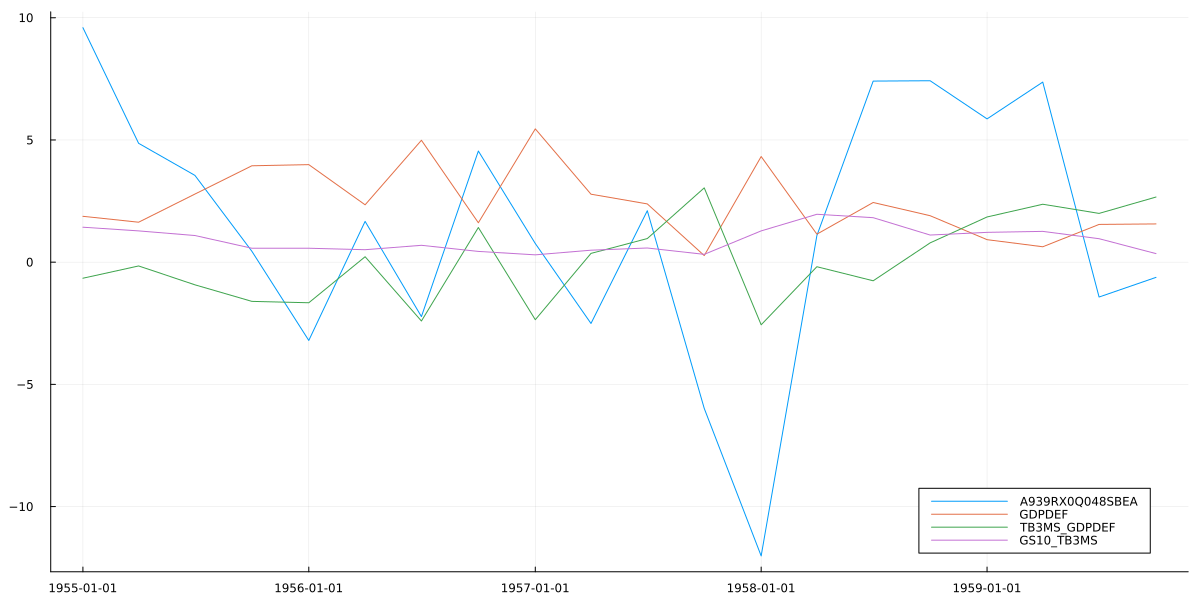

In [162]:
plot(presample; size=(1200, 600))

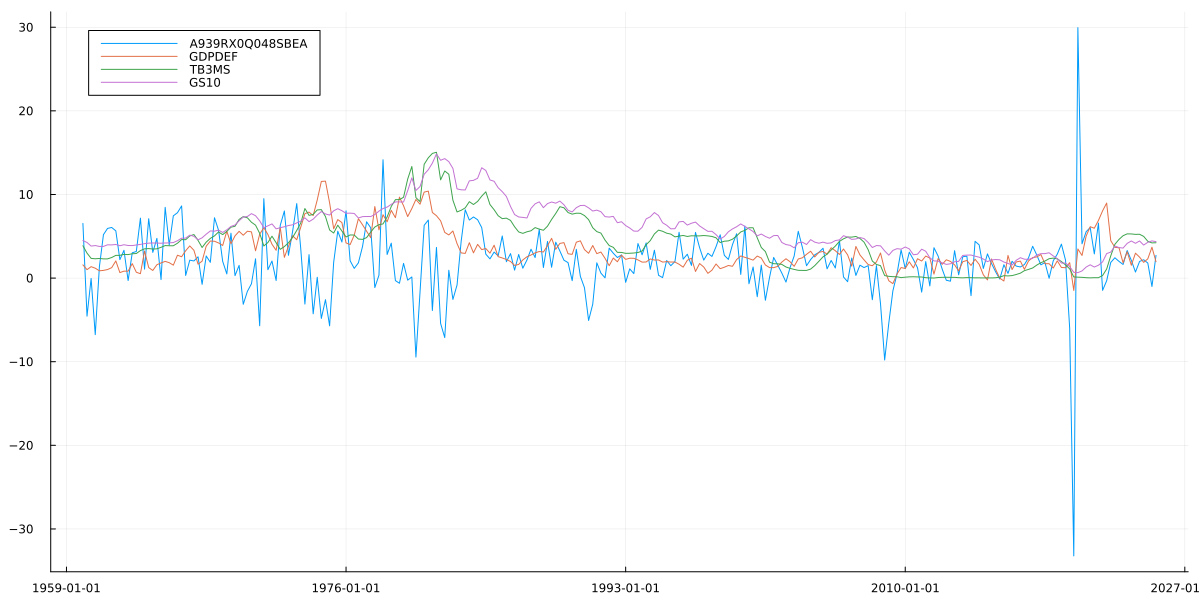

In [77]:
plot(data; size=(1200, 600))

In [163]:
presample_mean = mean(presample)
presample_mean = round.(presample_mean, digits=2)
display("presample mean")
display(presample_mean)

presample_variance = var(presample)
presample_variance = round.(presample_variance, digits=2)
display("presample variance")
display(presample_variance)
display(presample_variance .^ .5) 

"presample mean"

1×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1959-10-01 to 1959-10-01
┌────────────┬─────────────────┬────────┬──────────────┬────────────┐
│            │ A939RX0Q048SBEA │ GDPDEF │ TB3MS_GDPDEF │ GS10_TB3MS │
├────────────┼─────────────────┼────────┼──────────────┼────────────┤
│ 1959-10-01 │            1.44 │   2.43 │         0.12 │       0.91 │
└────────────┴─────────────────┴────────┴──────────────┴────────────┘

"presample variance"

1×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1959-10-01 to 1959-10-01
┌────────────┬─────────────────┬────────┬──────────────┬────────────┐
│            │ A939RX0Q048SBEA │ GDPDEF │ TB3MS_GDPDEF │ GS10_TB3MS │
├────────────┼─────────────────┼────────┼──────────────┼────────────┤
│ 1959-10-01 │           27.36 │   2.08 │         3.05 │       0.25 │
└────────────┴─────────────────┴────────┴──────────────┴────────────┘

1×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 1959-10-01 to 1959-10-01
┌────────────┬─────────────────┬─────────┬──────────────┬────────────┐
│            │ A939RX0Q048SBEA │ GDPDEF  │ TB3MS_GDPDEF │ GS10_TB3MS │
├────────────┼─────────────────┼─────────┼──────────────┼────────────┤
│ 1959-10-01 │         5.23068 │ 1.44222 │      1.74642 │        0.5 │
└────────────┴─────────────────┴─────────┴──────────────┴────────────┘

In [164]:
n = 4 #number of observatin variables

priors = (
        initial_trend_mean = values(presample_mean)[1,:],
        initial_cycle_mean = zeros(n),
        initial_trend_covariance = diagm(fill(1,n)),
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([2.5, 5, 5, 5] ./ 400),
        cycle_coeff_mean = zeros(n, n),
        cycle_coeff_shrinkage_param = .2,
        cycle_covariance_mean = diagm(values(presample_variance)[1,:]), #diagm(presample_variance), 
        cycle_covariance_df = n+2
        )


(initial_trend_mean = [1.44, 2.43, 0.12, 0.91], initial_cycle_mean = [0.0, 0.0, 0.0, 0.0], initial_trend_covariance = [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1], trend_covariance_df = 100, trend_covariance_mean = [0.00625 0.0 0.0 0.0; 0.0 0.0125 0.0 0.0; 0.0 0.0 0.0125 0.0; 0.0 0.0 0.0 0.0125], cycle_coeff_mean = [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], cycle_coeff_shrinkage_param = 0.2, cycle_covariance_mean = [27.36 0.0 0.0 0.0; 0.0 2.08 0.0 0.0; 0.0 0.0 3.05 0.0; 0.0 0.0 0.0 0.25], cycle_covariance_df = 6)

In [165]:
priors.cycle_covariance_mean

4×4 Matrix{Float64}:
 27.36  0.0   0.0   0.0
  0.0   2.08  0.0   0.0
  0.0   0.0   3.05  0.0
  0.0   0.0   0.0   0.25

In [194]:
observation_tend_mapping  = [1 0 0 0 
                             0 1 0 0 
                             0 1 1 0 
                             0 1 1 1 ]

trend_states_samples, cycle_states_samples, trend_covariance_samples, betas_samples, sigmas_samples = TCVAR.gibs_sampler(values(data), observation_tend_mapping, priors; burnin = 50_000, n_samples = 50_000, thin=25)

trend_states_mean, trend_states_lower, trend_states_upper = TCVAR.compute_posterior_statistics(trend_states_samples, credible_level=0.95)  
cycle_states_mean, cycle_states_lower, cycle_states_upper = TCVAR.compute_posterior_statistics(cycle_states_samples, credible_level=0.95) 

([4.2164872682324726 -0.9544091990914472 0.5858591815460521 0.2434591241403862; -6.877025702671437 -1.511103935983726 -0.2717869749256249 0.04583525888393781; … ; -2.6890824227496006 0.9388730332889668 1.2272996905949598 0.39247883700202857; 1.0308870509617705 -0.7796307588387427 1.2582834553440785 0.31571647935169644], [3.2915877680410737 -2.1946011826136216 -0.9977090210091375 -1.484252766884731; -7.763265615823013 -2.779393485838271 -1.871587082539954 -1.7417780687836462; … ; -3.7545844406757207 -1.149028694919808 -1.7562283529785145 -3.6967081030477633; -0.049185719854605306 -2.9110489292306343 -1.6186942652566294 -3.8164499280966515], [5.163528628791312 0.24175039247057645 2.2456384981448254 2.019144904806347; -5.904404352733638 -0.33465058044295604 1.456104979911261 1.9130079055928577; … ; -1.6359834987377657 3.2108795403594583 4.263373666572254 4.990089649417691; 2.110428636786728 1.4696307330467127 4.2720522909410965 4.878209736566321])

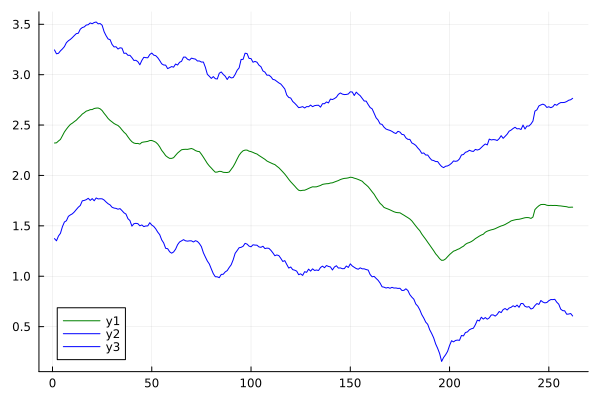

In [195]:
st = 1
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

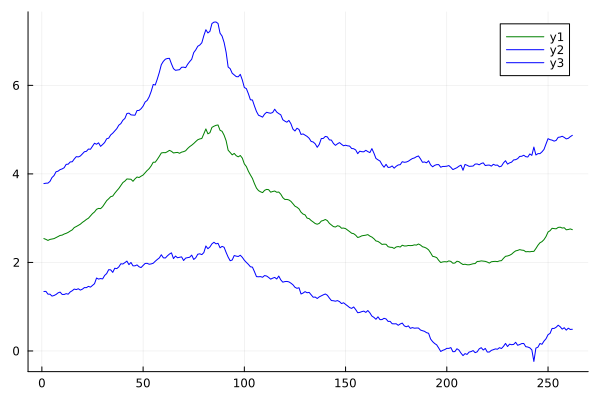

In [196]:
st = 2
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

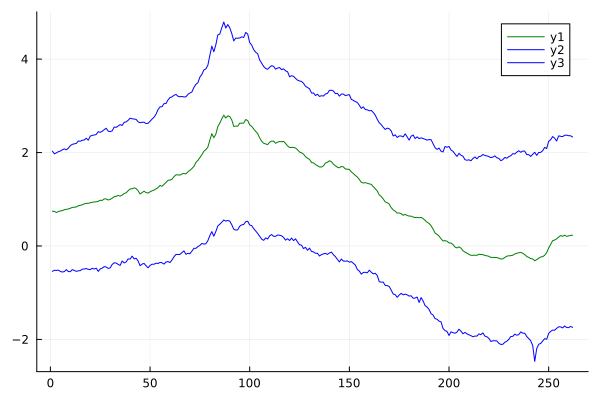

In [197]:
st = 3
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

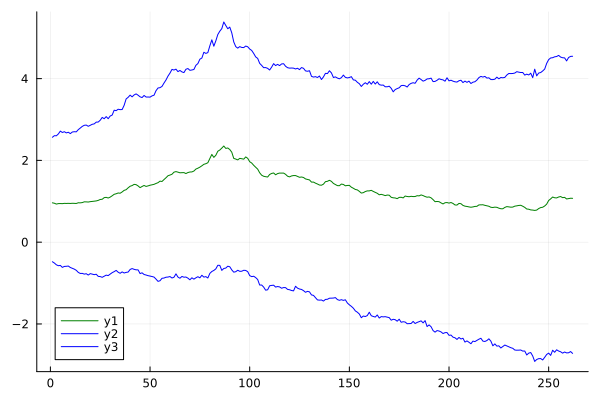

In [198]:
st = 4
plot(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

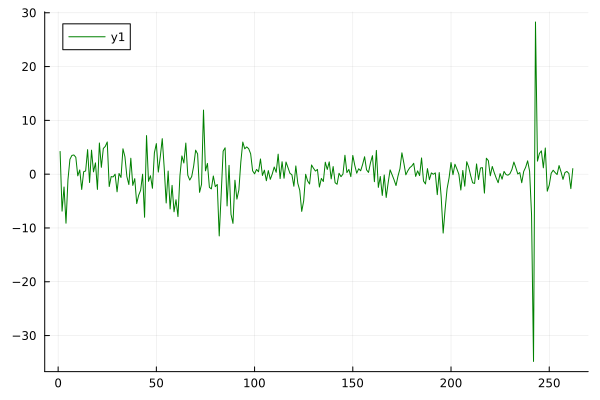

In [199]:
st=1
plot(cycle_states_mean[:,st], color="green" )

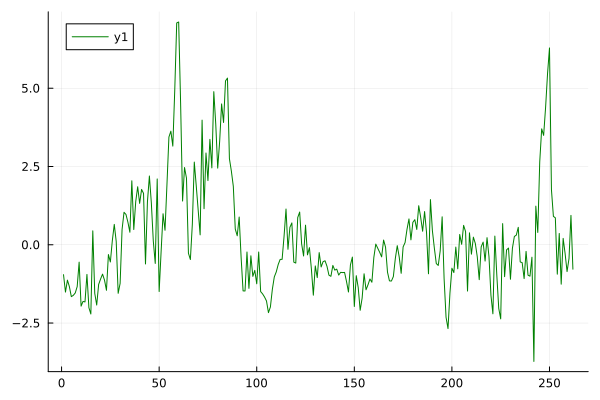

In [200]:
st=2
plot(cycle_states_mean[:,st], color="green" )

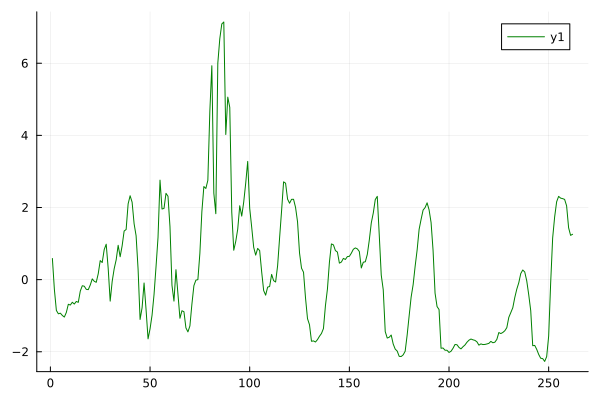

In [201]:
st=3
plot(cycle_states_mean[:,st], color="green" )

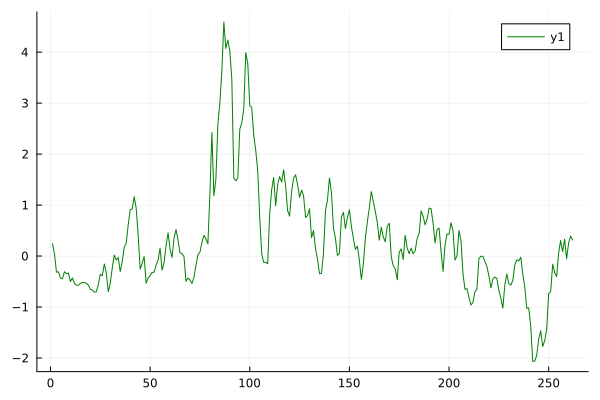

In [202]:
st=4
plot(cycle_states_mean[:,st], color="green" )

In [203]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         Στ1    0.0080    0.0019    0.0000   1883.6554   1914.2659    0.9996   ⋯
         Στ2   -0.0001    0.0027    0.0001   1919.8124   1963.8759    1.0002   ⋯
         Στ3    0.0002    0.0025    0.0001   1943.7546   1878.7411    1.0014   ⋯
         Στ4   -0.0001    0.0026    0.0001   1937.2815   1731.3164    0.9997   ⋯
         Στ5   -0.0001    0.0027    0.0001   1919.8124   1963.8759    1.0002   ⋯
         Στ6    0.0221    0.0101    0.0002   1618.5424   1796.7850    0.9999   ⋯
         Στ7    0.0063    0.0085    0.0002   1809.3138   1939.3506    0.9999   ⋯
         Στ8    0.0065    0.0093    0.0002   1640.6310   1716.3652    0.9995   ⋯
         Στ9    0.0002    0.0025    0.0001   1943.7546   1878.7411    1.0014   ⋯
        Στ10    0.0063    0.0085    0.0002   1809.3138   1939.3506    0.9999   ⋯
        

In [204]:
summarystats(betas_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         Σc1   -0.0132    0.0649    0.0014   2055.0263   1762.5946    0.9998   ⋯
         Σc2   -0.2890    0.2102    0.0048   1888.0307   1842.4429    1.0002   ⋯
         Σc3   -0.3124    0.2261    0.0058   1543.2415   1978.7778    1.0020   ⋯
         Σc4    0.0098    0.3287    0.0072   2077.3224   1890.9935    0.9997   ⋯
         Σc5   -0.0165    0.0289    0.0006   2224.4610   1920.3398    0.9996   ⋯
         Σc6    0.7166    0.1017    0.0023   1883.8764   1995.8188    0.9996   ⋯
         Σc7    0.0761    0.0865    0.0019   2049.8087   2027.8625    1.0003   ⋯
         Σc8   -0.0708    0.1321    0.0029   2064.9995   1955.0198    1.0011   ⋯
         Σc9    0.0158    0.0330    0.0007   2039.7204   2090.1638    1.0049   ⋯
        Σc10    0.0802    0.0721    0.0017   1718.0092   1961.5296    1.0009   ⋯
        

In [205]:
summarystats(sigmas_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         Σc1   18.7070    1.6070    0.0379   1806.5540   1890.8614    1.0002   ⋯
         Σc2    0.8911    0.4974    0.0116   1841.0990   1721.3093    0.9997   ⋯
         Σc3    0.6779    0.5023    0.0113   1961.4370   1962.7334    1.0012   ⋯
         Σc4    0.3092    0.3714    0.0083   1931.3905   1920.7541    0.9999   ⋯
         Σc5    0.8911    0.4974    0.0116   1841.0990   1721.3093    0.9997   ⋯
         Σc6    3.0476    1.5989    0.0372   1636.1303   1919.3530    0.9998   ⋯
         Σc7    1.6937    1.1464    0.0261   1905.9417   1864.4741    1.0024   ⋯
         Σc8    0.2440    1.4536    0.0323   2121.2755   2004.1388    0.9997   ⋯
         Σc9    0.6779    0.5023    0.0113   1961.4370   1962.7334    1.0012   ⋯
        Σc10    1.6937    1.1464    0.0261   1905.9417   1864.4741    1.0024   ⋯
        

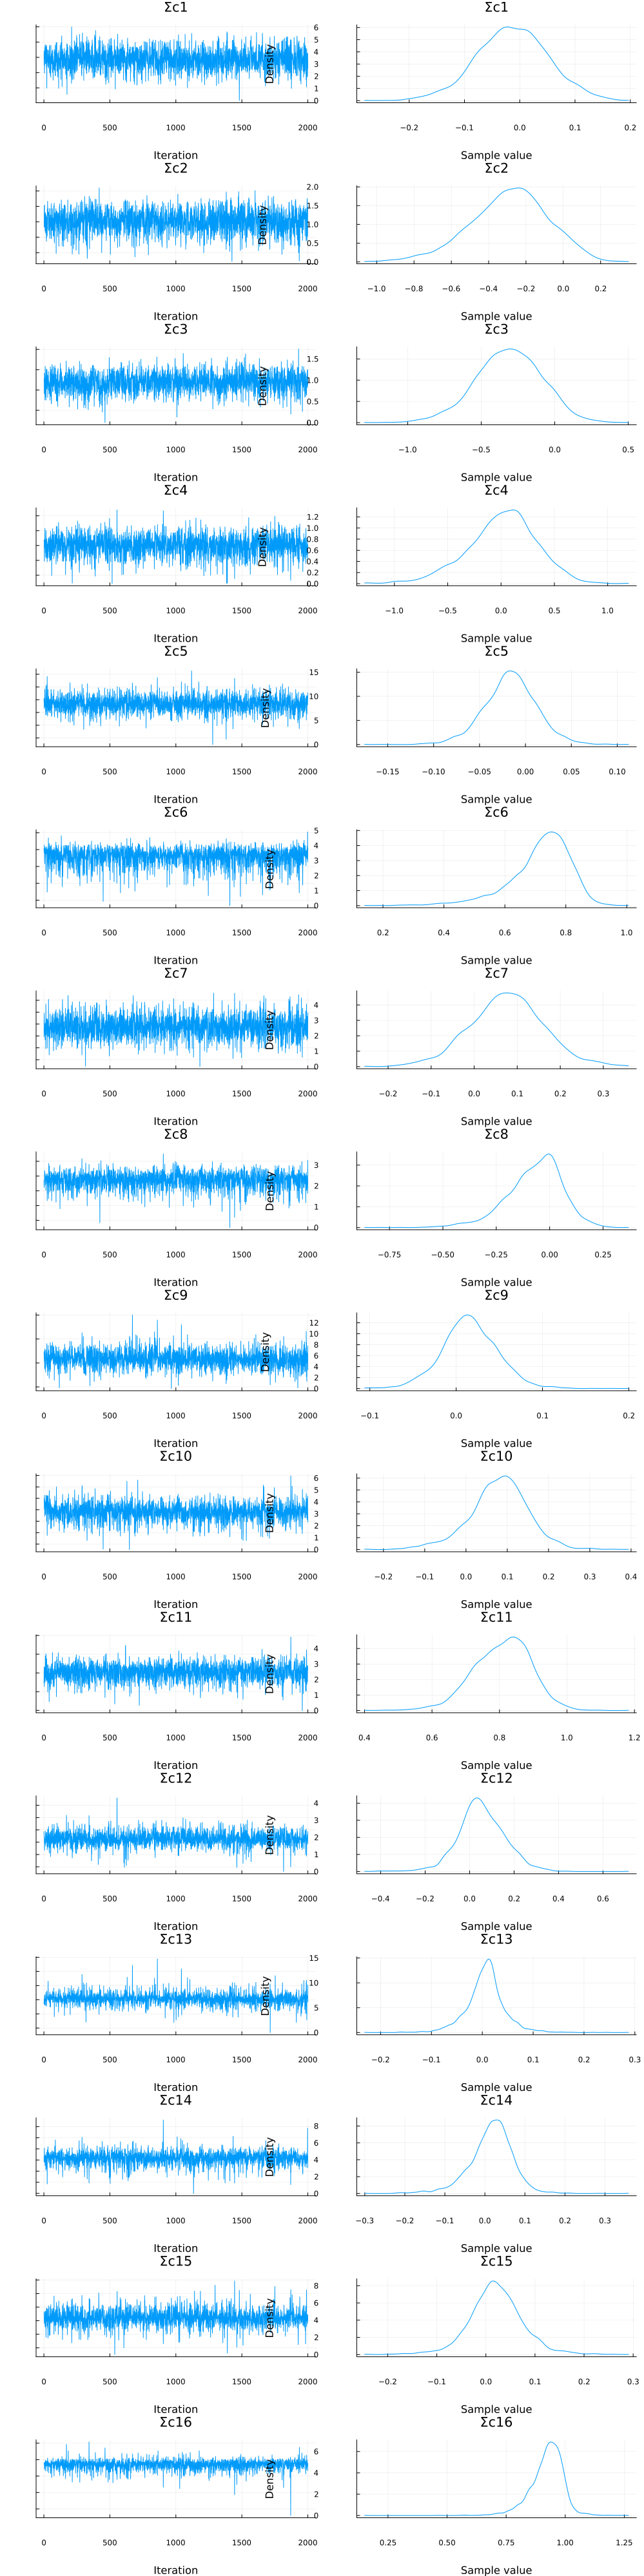

In [206]:
plot(betas_samples)